In [1]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
pip install opencv-python

In [3]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/catndog.zip 파일 선택

Saving catanddog.zip to catanddog.zip


In [4]:
!unzip catanddog.zip -d catanddog/    #catanddog 폴더 만들어 압축 풀기

Archive:  catanddog.zip
   creating: catanddog/test/
   creating: catanddog/test/Cat/
  inflating: catanddog/test/Cat/8100.jpg  
  inflating: catanddog/test/Cat/8101.jpg  
  inflating: catanddog/test/Cat/8102.jpg  
  inflating: catanddog/test/Cat/8103.jpg  
  inflating: catanddog/test/Cat/8104.jpg  
  inflating: catanddog/test/Cat/8105.jpg  
  inflating: catanddog/test/Cat/8106.jpg  
  inflating: catanddog/test/Cat/8107.jpg  
  inflating: catanddog/test/Cat/8108.jpg  
  inflating: catanddog/test/Cat/8109.jpg  
  inflating: catanddog/test/Cat/8110.jpg  
  inflating: catanddog/test/Cat/8111.jpg  
  inflating: catanddog/test/Cat/8112.jpg  
  inflating: catanddog/test/Cat/8113.jpg  
  inflating: catanddog/test/Cat/8114.jpg  
  inflating: catanddog/test/Cat/8115.jpg  
  inflating: catanddog/test/Cat/8116.jpg  
  inflating: catanddog/test/Cat/8117.jpg  
  inflating: catanddog/test/Cat/8118.jpg  
  inflating: catanddog/test/Cat/8119.jpg  
  inflating: catanddog/test/Cat/8120.jpg  
  inflating

In [20]:
data_path = 'catanddog/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

385


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
pip install mxnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.1 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3


In [8]:
pip install --user mxnet

In [11]:
pip install mxnet

In [17]:
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet.gluon.data.vision import transforms

/usr/local/lib/python3.10/dist-packages/mxnet/numpy/utils.py:37: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  bool = onp.bool


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [15]:
example_image = mx.image.imread("./cat.jpg")
plt.imshow(example_image.asnumpy())

NameError: name 'mx' is not defined

In [13]:
def show_images(imgs, num_rows, num_cols, scale=2):
    aspect_ratio = imgs[0].shape[0]/imgs[0].shape[1]
    figsize = (num_cols * scale, num_rows * scale * aspect_ratio)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j].asnumpy())
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    plt.subplots_adjust(hspace=0.1, wspace=0)
    return axes

def apply(img, aug, num_rows=2, num_cols=4, scale=3):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

In [14]:
shape_aug = transforms.RandomResizedCrop(size=(200, 200),
                                         scale=(0.1, 1),
                                         ratio=(0.5, 2))
apply(example_image, shape_aug)

NameError: name 'example_image' is not defined

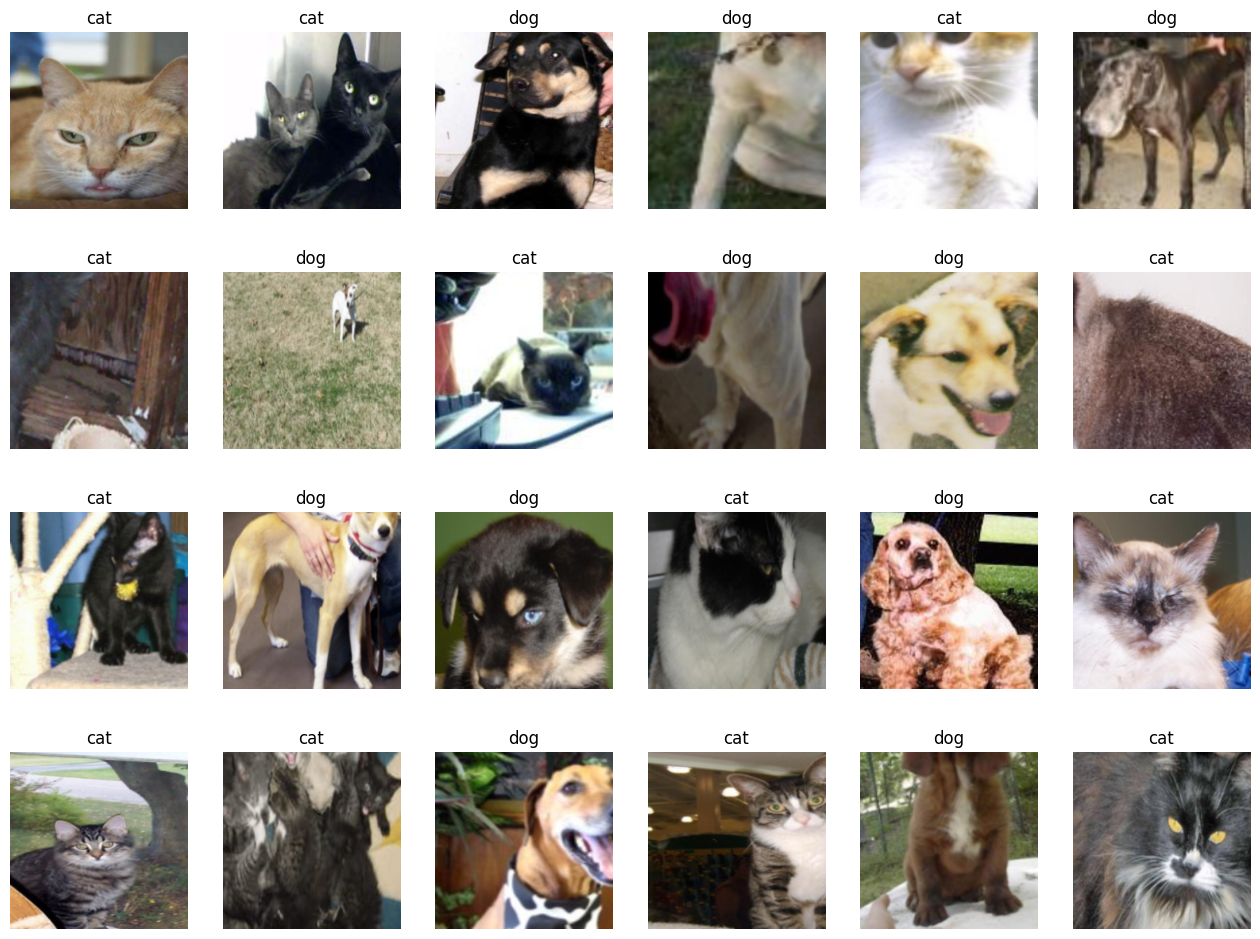

In [21]:
import numpy as np
samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [22]:
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


In [23]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [24]:
resnet18.fc = nn.Linear(512, 2)

In [25]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0374, -0.0142, -0.0315,  ...,  0.0145, -0.0319, -0.0184],
        [ 0.0302, -0.0114,  0.0164,  ...,  0.0100,  0.0441,  0.0048]])
fc.bias tensor([ 0.0376, -0.0105])


In [26]:
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [28]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.5528 Acc: 0.7091

Epoch 1/12
----------
Loss: 0.3758 Acc: 0.8390

Epoch 2/12
----------
Loss: 0.3430 Acc: 0.8390

Epoch 3/12
----------
Loss: 0.2626 Acc: 0.9117

Epoch 4/12
----------
Loss: 0.3045 Acc: 0.8571

Epoch 5/12
----------
Loss: 0.3979 Acc: 0.8130

Epoch 6/12
----------
Loss: 0.3846 Acc: 0.8260

Epoch 7/12
----------
Loss: 0.3364 Acc: 0.8260

Epoch 8/12
----------
Loss: 0.3431 Acc: 0.8416

Epoch 9/12
----------
Loss: 0.1916 Acc: 0.9351

Epoch 10/12
----------
Loss: 0.1839 Acc: 0.9351

Epoch 11/12
----------
Loss: 0.2098 Acc: 0.9039

Epoch 12/12
----------
Loss: 0.2313 Acc: 0.9169

Training complete in 9m 46s
Best Acc: 0.935065


In [31]:
test_path = 'catanddog/test/'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [32]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [33]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['catanddog/00.pth', 'catanddog/01.pth', 'catanddog/02.pth', 'catanddog/03.pth', 'catanddog/04.pth', 'catanddog/05.pth', 'catanddog/06.pth', 'catanddog/07.pth', 'catanddog/08.pth', 'catanddog/09.pth', 'catanddog/10.pth', 'catanddog/11.pth', 'catanddog/12.pth']
Loading model catanddog/00.pth


<ipython-input-32-72f80e6eb023>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Acc: 0.9388

Loading model catanddog/01.pth
Acc: 0.8980

Loading model catanddog/02.pth
Acc: 0.9388

Loading model catanddog/03.pth
Acc: 0.9490

Loading model catanddog/04.pth
Acc: 0.9490

Loading model catanddog/05.pth
Acc: 0.9592

Loading model catanddog/06.pth
Acc: 0.9184

Loading model catanddog/07.pth
Acc: 0.9592

Loading model catanddog/08.pth
Acc: 0.9082

Loading model catanddog/09.pth
Acc: 0.9592

Loading model catanddog/10.pth
Acc: 0.9082

Loading model catanddog/11.pth
Acc: 0.9286

Loading model catanddog/12.pth
Acc: 0.9592

Validation complete in 2m 37s
Best Acc: 0.959184


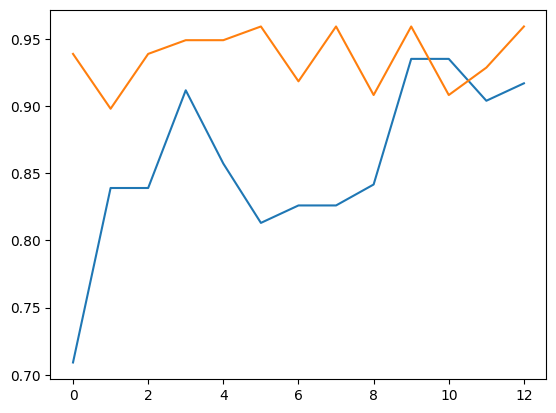

In [34]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

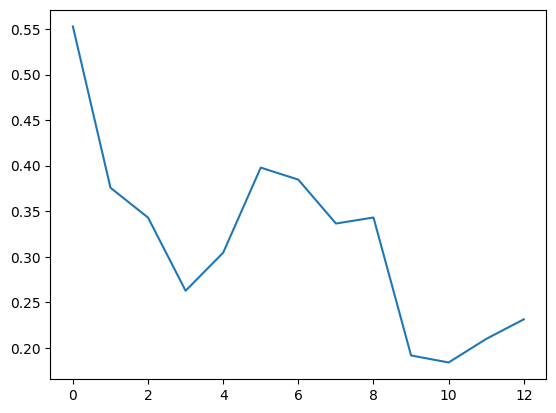

In [35]:
plt.plot(train_loss_hist)
plt.show()

In [36]:
def im_convert(tensor):
    image=tensor.clone().detach().numpy()
    image=image.transpose(1,2,0)
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
    image=image.clip(0,1)
    return image

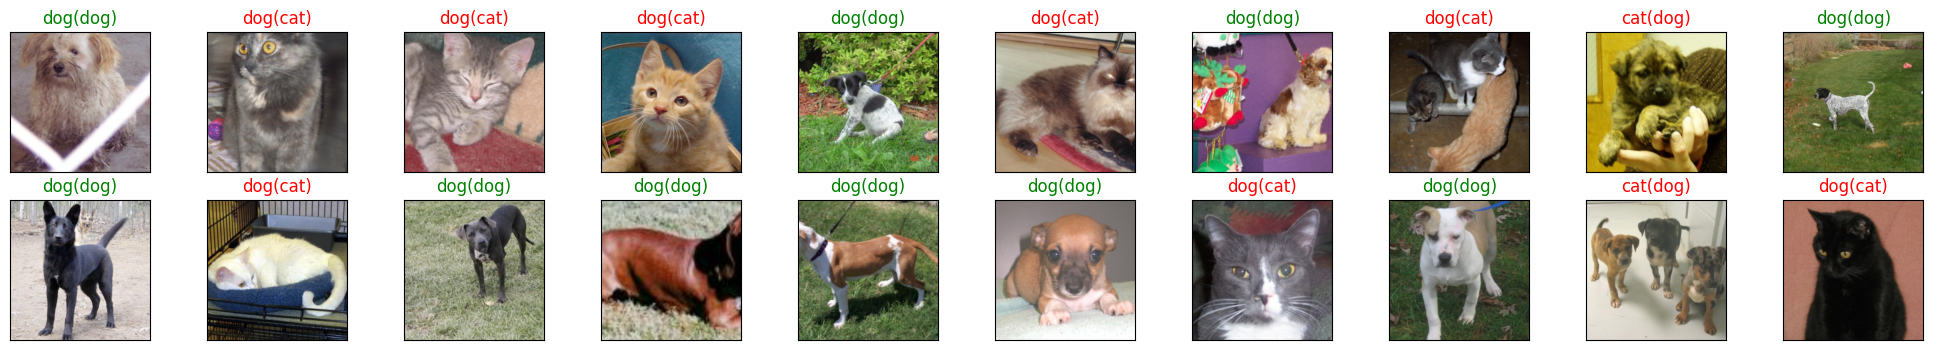

<Figure size 640x480 with 0 Axes>

In [38]:
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)
images, labels = next(dataiter)
output=model(images)
_,preds=torch.max(output,1)

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [39]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)

In [41]:
model=XAI()
model.cpu() #모델에 입력되는 이미지를 넘파이로 받아오는 부분 -> CPU를 사용
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [42]:
class LayerActivations:
    features=[]
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        output = output
        #self.features = output.to(device).detach().numpy()
        self.features = output.detach().numpy()
    def remove(self):
        self.hook.remove()

Saving cat.jpg to cat (1).jpg
torch.Size([1, 3, 100, 100])


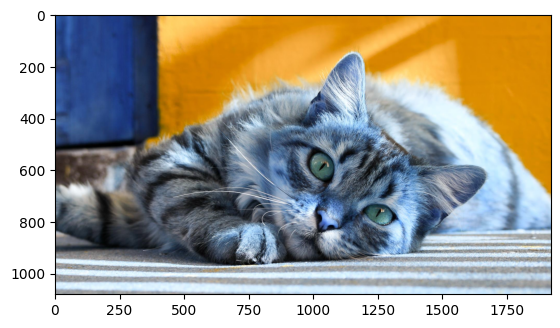

In [43]:
from google.colab import files
file_uploaded=files.upload()

img=cv2.imread("cat.jpg")
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)

print(img.shape)

In [44]:
result = LayerActivations(model.features, 0)
model(img)
activations = result.features

<ipython-input-40-5fb1fce6f707>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


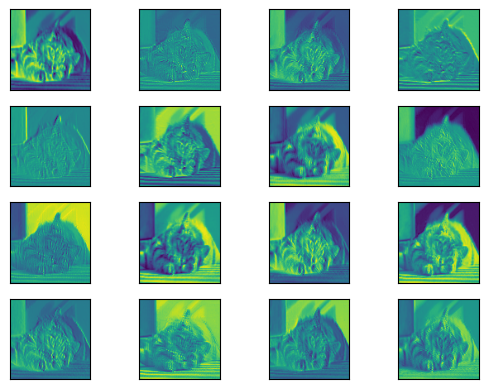

<Figure size 1200x800 with 0 Axes>

In [45]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [46]:
result = LayerActivations(model.features, 20)

model(img)
activations = result.features

<ipython-input-40-5fb1fce6f707>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


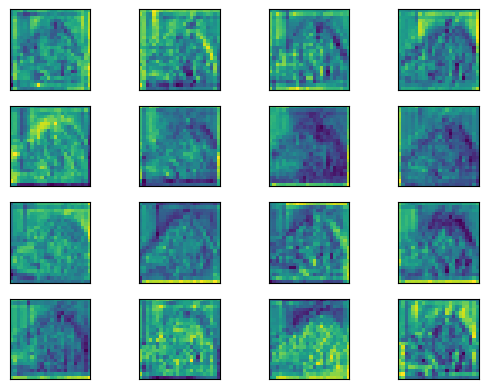

<Figure size 1200x800 with 0 Axes>

In [47]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [48]:
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

<ipython-input-40-5fb1fce6f707>:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


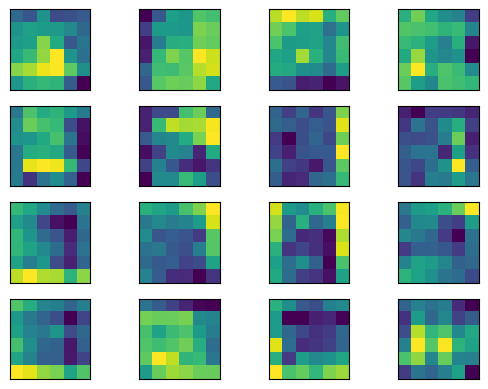

<Figure size 1200x800 with 0 Axes>

In [49]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()